In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [ ]:
seed_everything(42)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/농산물AI/test_files/train.csv')

In [ ]:
week_day_map = {}
for i, d in enumerate(data['요일'].unique()):
    week_day_map[d] = i
data['요일'] = data['요일'].map(week_day_map)

In [ ]:
norm = data.iloc[:, 1:].max(0)
data.iloc[:, 1:] = data.iloc[:, 1:] / norm

In [ ]:

device = torch.device("cuda:0") # GPU 사용
target_n = 21 # 맞춰야하는 품목/품종의 수
learning_rate = 5e-4 # 학습률
BATCH_SIZE = 128 # 배치사이즈
EPOCHS = 50 # 총 eopochs
teacher_forcing = False # 교사강요 설정
n_layers = 3 # rnn레이어 층
dropout = 0.2 # 드롭아웃
window_size = 28 # 인코더 시퀀스 길이
future_size = 28 # 디코더 시퀀스 길이
hidden_dim = 128 # rnn 히든차원
save_path = f'/content/drive/MyDrive/best_model.pt' # 모델 저장 경로

In [ ]:
x_data = []
y_data = []
for i in range(data.shape[0]-window_size-future_size):
    x = data.iloc[i:i+window_size, 1:].to_numpy()
    y = data.iloc[i+window_size:i+window_size+future_size, 3::2].to_numpy()
    y_0 = np.zeros([1, y.shape[1]]) # 디코더 첫 입력값 추가
    x_data.append(x)
    y_data.append(np.concatenate([y_0, y], axis=0))
x_data = np.array(x_data)
y_data = np.array(y_data)

In [ ]:
x_data.shape, y_data.shape

((1677, 28, 43), (1677, 29, 21))

In [ ]:
train_test_split = 1
x_train = x_data[:-train_test_split-future_size]
y_train = y_data[:-train_test_split-future_size]
x_val = x_data[-train_test_split:]
y_val = y_data[-train_test_split:]

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, encoder_input, decoder_input):
        self.encoder_input = encoder_input
        self.decoder_input = decoder_input
        
    def __len__(self):
        return len(self.encoder_input)
    
    def __getitem__(self, i):
        return {
            'encoder_input' : torch.tensor(self.encoder_input[i], dtype=torch.float32),
            'decoder_input' : torch.tensor(self.decoder_input[i], dtype=torch.float32)
        }

In [ ]:
train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
sample_batch = next(iter(train_dataloader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
sample_batch['encoder_input'].shape, sample_batch['decoder_input'].shape

(torch.Size([128, 28, 43]), torch.Size([128, 29, 21]))

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.n_layers = n_layers
        
        self.rnn = nn.GRU(input_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp_seq):
        inp_seq = inp_seq.permute(1,0,2)
        outputs, hidden = self.rnn(inp_seq)
        
        return outputs, hidden

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, dec_output_dim, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = nn.Linear(dec_output_dim, units)
        self.W2 = nn.Linear(dec_output_dim, units)
        self.V = nn.Linear(dec_output_dim, 1)

    def forward(self, hidden, enc_output):
        query_with_time_axis = hidden.unsqueeze(1)
        
        score = self.V(torch.tanh(self.W1(query_with_time_axis) + self.W2(enc_output)))
        
        attention_weights = torch.softmax(score, axis=1)
        
        context_vector = attention_weights * enc_output
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector, attention_weights

In [ ]:
class Decoder(nn.Module):
    def __init__(self, dec_feature_size, encoder_hidden_dim, output_dim, decoder_hidden_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.n_layers = n_layers
        self.attention = attention
        
        self.layer = nn.Linear(dec_feature_size, encoder_hidden_dim)
        self.rnn = nn.GRU(encoder_hidden_dim*2, decoder_hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, enc_output, dec_input, hidden):
        dec_input = self.layer(dec_input)
        context_vector, attention_weights = self.attention(hidden, enc_output)
        dec_input = torch.cat([torch.sum(context_vector, dim=0), dec_input], dim=1)
        dec_input = dec_input.unsqueeze(0)
        
        output, hidden = self.rnn(dec_input, hidden)

        prediction = self.fc_out(output.sum(0))
        
        return prediction, hidden

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, attention):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, encoder_input, decoder_input, teacher_forcing=False):
        batch_size = decoder_input.size(0)
        trg_len = decoder_input.size(1)
        
        outputs = torch.zeros(batch_size, trg_len-1, self.decoder.output_dim).to(device)
        enc_output, hidden = self.encoder(encoder_input)
        
        dec_input = decoder_input[:, 0]
        for t in range(1, trg_len):
            output, hidden = self.decoder(enc_output, dec_input, hidden)
            outputs[:, t-1] = output
            if teacher_forcing == True:
                dec_input = decoder_input[:, t]
            else:
                dec_input = output
        
        return outputs

In [ ]:
encoder = Encoder(input_dim=x_data.shape[-1], hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout)
attention = BahdanauAttention(dec_output_dim=hidden_dim, units=hidden_dim)
decoder = Decoder(
    dec_feature_size=target_n, encoder_hidden_dim=hidden_dim, output_dim=target_n,
    decoder_hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout,
    attention = attention
)

model = Seq2Seq(encoder, decoder, attention)
model = model.to(device)

In [ ]:
def my_custom_metric(pred, true):
    pred = pred[:, [6, 13, 27]]
    true = true[:, [6, 13, 27]]
    target = torch.where(true!=0)
    true = true[target]
    pred = pred[target]
    score = torch.mean(torch.abs((true-pred))/(true))
    
    return score

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss() # mae
custom_metric = my_custom_metric

In [ ]:
def train_step(batch_item, epoch, batch, training, teacher_forcing):
    encoder_input = batch_item['encoder_input'].to(device)
    decoder_input = batch_item['decoder_input'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(encoder_input, decoder_input, teacher_forcing)
            loss = criterion(output, decoder_input[:,1:])
            score = custom_metric(output, decoder_input[:,1:])
        loss.backward()
        optimizer.step()
        
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(encoder_input, decoder_input, False)
            loss = criterion(output, decoder_input[:,1:])
            score = custom_metric(output, decoder_input[:,1:])
        return loss, score

In [ ]:
loss_plot, val_loss_plot = [], []
score_plot, val_score_plot = [], []

for epoch in range(EPOCHS):
    total_loss, total_val_loss = 0, 0
    total_score, total_val_score = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_score = train_step(batch_item, epoch, batch, training, teacher_forcing)
        total_loss += batch_loss
        total_score += batch_score
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Score': '{:06f}'.format(batch_score.item()),
            'Total Score' : '{:06f}'.format(total_score/(batch+1)),
        })
    loss_plot.append(total_loss/(batch+1))
    score_plot.append(total_score/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_val_score = train_step(batch_item, epoch, batch, training, teacher_forcing)
        total_val_loss += batch_loss
        total_val_score += batch_val_score
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Val Score': '{:06f}'.format(batch_val_score.item()),
            'Total Val Score' : '{:06f}'.format(total_val_score/(batch+1)),
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_score_plot.append(total_val_score/(batch+1))
    
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model, save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
0it [00:00, ?it/s]

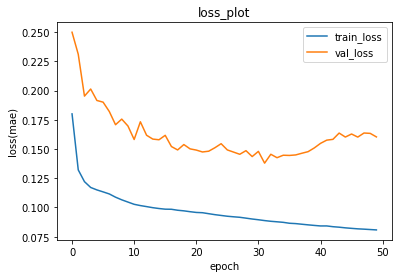

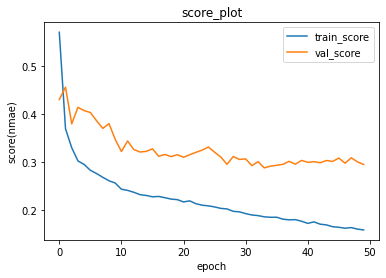

In [ ]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.title('loss_plot')
plt.legend()
plt.show()

plt.plot(score_plot, label='train_score')
plt.plot(val_score_plot, label='val_score')
plt.xlabel('epoch')
plt.ylabel('score(nmae)')
plt.title('score_plot')
plt.legend()
plt.show()

In [ ]:
model = torch.load(save_path)
model = model.to(device)

In [ ]:
def predict(encoder_input):
    model.train()
    encoder_input = encoder_input.to(device)
    decoder_input = torch.zeros([1, future_size+1, target_n], dtype=torch.float32).to(device)
    with torch.no_grad():
        output = model(encoder_input, decoder_input, False)
    return output.cpu()

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/농산물AI/sample_submission.csv')

In [ ]:
public_date_list = submission[submission['예측대상일자'].str.contains('2020')]['예측대상일자'].str.split('+').str[0].unique()

In [ ]:
outputs = []
troch_norm = torch.tensor(norm.to_numpy()[2::2])
for date in public_date_list:
    test_df = pd.read_csv(f'/content/drive/MyDrive/농산물AI/test_files/test_{date}.csv')
    data = pd.read_csv('/content/drive/MyDrive/농산물AI/test_files/train.csv')
    data = pd.concat([data, test_df]).iloc[-window_size:]
    
    week_day_map = {}
    for i, d in enumerate(data['요일'].unique()):
        week_day_map[d] = i
    data['요일'] = data['요일'].map(week_day_map)
    data = data.iloc[:,1:]/norm
    
    encoder_input = torch.tensor(data.to_numpy(), dtype=torch.float32)
    encoder_input = encoder_input.unsqueeze(0)
    output = predict(encoder_input)*troch_norm
    
    idx = submission[submission['예측대상일자'].str.contains(date)].index
    submission.loc[idx, '배추_가격(원/kg)':] = output[0,[6,13,27]].numpy()

In [ ]:
submission.to_csv('dacon_baseline.csv', index=False)